In [1]:
# 📦 Step 1: Import Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Add the parent directory to the Python path
 # to handle ModuleNotFoundError: No module named 'models' error
import sys
sys.path.append('../') 

from models.timeseries_dataset_class import TimeSeriesDataset
from models.transformer_model_definitions import ProbSparseSelfAttention,InformerBlock,InformerForecast

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cpu


In [2]:
# 📂 Step 2: Load Preprocessed Data
df = pd.read_csv("../data/processed/etth1_processed.csv", parse_dates=["date"], index_col="date")
target = df["OT"].values

In [3]:
# 🔄 Step 3: Dataloader
window_size = 96
batch_size = 32
dataset = TimeSeriesDataset(target, window_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
# ⚙️ Step 4: Train the Informer Model
model = InformerForecast().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device).unsqueeze(1)
        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {total_loss / len(dataloader):.4f}")

# Save the trained model
torch.save(model.state_dict(), '../models/checkpoints/informer_transformer_model.pth')

Epoch 1 | Loss: 0.0019
Epoch 2 | Loss: 0.0004
Epoch 3 | Loss: 0.0004
Epoch 4 | Loss: 0.0004
Epoch 5 | Loss: 0.0004
Epoch 6 | Loss: 0.0004
Epoch 7 | Loss: 0.0004
Epoch 8 | Loss: 0.0004
Epoch 9 | Loss: 0.0004
Epoch 10 | Loss: 0.0004


In [8]:
# Evaluation
model.eval()
predictions = []
true_values = []
with torch.no_grad():
    for x, y in dataloader:
        x, y = x.to(device), y.to(device).unsqueeze(1)
        pred = model(x)
        predictions.append(pred.cpu().numpy())
        true_values.append(y.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
true_values = np.concatenate(true_values, axis=0)

# Inverse transform predictions and true values
# Add dummy columns to match the scaler's expected input shape
dummy_shape = (predictions.shape[0], df.shape[1])  # Match the number of columns in the original data
predictions_full = np.zeros(dummy_shape)
true_values_full = np.zeros(dummy_shape)

# Fill the relevant column (e.g., 'OT') with predictions and true values
predictions_full[:, -1] = predictions.flatten()
true_values_full[:, -1] = true_values.flatten()

# Apply inverse transform
scaler = MinMaxScaler()
scaler.fit(df)  # Fit scaler on the original dataframe
predictions = scaler.inverse_transform(predictions_full)[:, -1]  # Extract the 'OT' column
true_values = scaler.inverse_transform(true_values_full)[:, -1]  # Extract the 'OT' column

MSE: 0.0004, MAE: 0.0134
Plot saved to ../../outputs/metrics/informer/informer_metrics.png


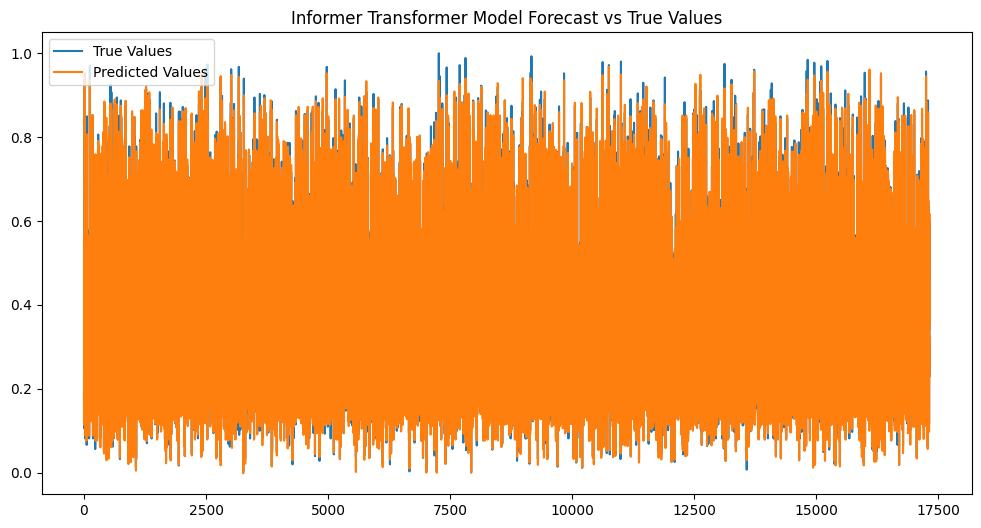

Results saved to .../../outputs/metrics/informer/informer_metrics.csv


In [12]:
#calculate metrics 
mse=mean_squared_error(true_values, predictions)
mae=mean_absolute_error(true_values, predictions)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

# Plot the results for comparison
plt.figure(figsize=(12, 6))
plt.plot(true_values, label="True Values")
plt.plot(predictions, label="Predicted Values")
plt.legend()
plt.title("Informer Transformer Model Forecast vs True Values")
# Save the plot as a PNG file before showing it
plt.savefig("../../outputs/metrics/informer/informer_metrics.png")
print("Plot saved to ../../outputs/metrics/informer/informer_metrics.png")

plt.show()

# Save the results for comparison
results = pd.DataFrame({
    "True Values": true_values.flatten(),
    "Predictions": predictions.flatten()
})

results.to_csv("../../outputs/metrics/informer/informer_metrics.csv", index=False)
print("Results saved to .../../outputs/metrics/informer/informer_metrics.csv")